In [ ]:
%%bash -e
if ! [[ -f ./linkern ]]; then
  wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
  echo 'c3650a59c8d57e0a00e81c1288b994a99c5aa03e5d96a314834c2d8f9505c724  co031219.tgz' | sha256sum -c
  tar xf co031219.tgz
  (cd concorde && CFLAGS='-Ofast -march=native -mtune=native -fPIC' ./configure)
  (cd concorde/LINKERN && make -j && cp linkern ../../)
  rm -rf concorde co031219.tgz
fi

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy

In [2]:
df = pd.read_csv('../data/raw/cities.csv', index_col=['CityId'])

In [3]:
df_1k = df * 1000

In [4]:
primes = list(sympy.primerange(0, max(df.index)))
df['prime'] = df.index.isin(primes).astype(int)
df_prime = df[(df.index == 0) | df['prime'] == 1]
df_prime_1k = df_prime * 1000

In [5]:
def write_tsp(cities, filename, name='traveling-santa-2018-prime-paths'):
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')
        f.write('DIMENSION : %d\n' % len(cities))
        f.write('EDGE_WEIGHT_TYPE : EUC_2D\n')
        f.write('NODE_COORD_SECTION\n')
        for row in cities.itertuples():
            f.write('%d %.11f %.11f\n' % (row.Index, row.X, row.Y))
        f.write('EOF\n')

In [6]:
write_tsp(df_prime_1k, 'prime.tsp')

In [9]:
%%bash
time ./linkern -s 42 -S prime.tour -R 999999999 -t 60 ./prime.tsp >linkern.log


real	1m0.602s
user	1m0.285s
sys	0m0.188s


       TSP tour length
28553        351093168
28604        351090731
28663        351088412
28853        351086891
28999        351086891


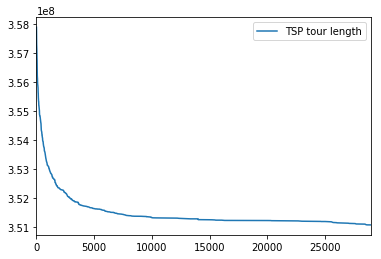

In [10]:
!sed -Ene 's/([0-9]+) Steps.*Best: ([0-9]+).*/\1,\2/p' linkern.log >linkern.csv
linkern_log = pd.read_csv('linkern.csv', index_col=0, names=['TSP tour length'])
print(linkern_log.tail())
linkern_log.plot()

In [63]:
def read_link(filename):
    data = open(filename, 'r').read()
    data = data.replace('\n', ' ')
    data = np.fromstring(data, sep=' ', dtype=np.int32)
    if len(data) != data[0] + 1:
        raise Exception('Unrecognized format in %s' % filename)
#     return data[1:]
    return np.concatenate((data[1:], [0]))

In [64]:
tour_data = read_link('prime.tour')
tour_data_2 = np.array([df_prime.index[x] for x in tour_data])

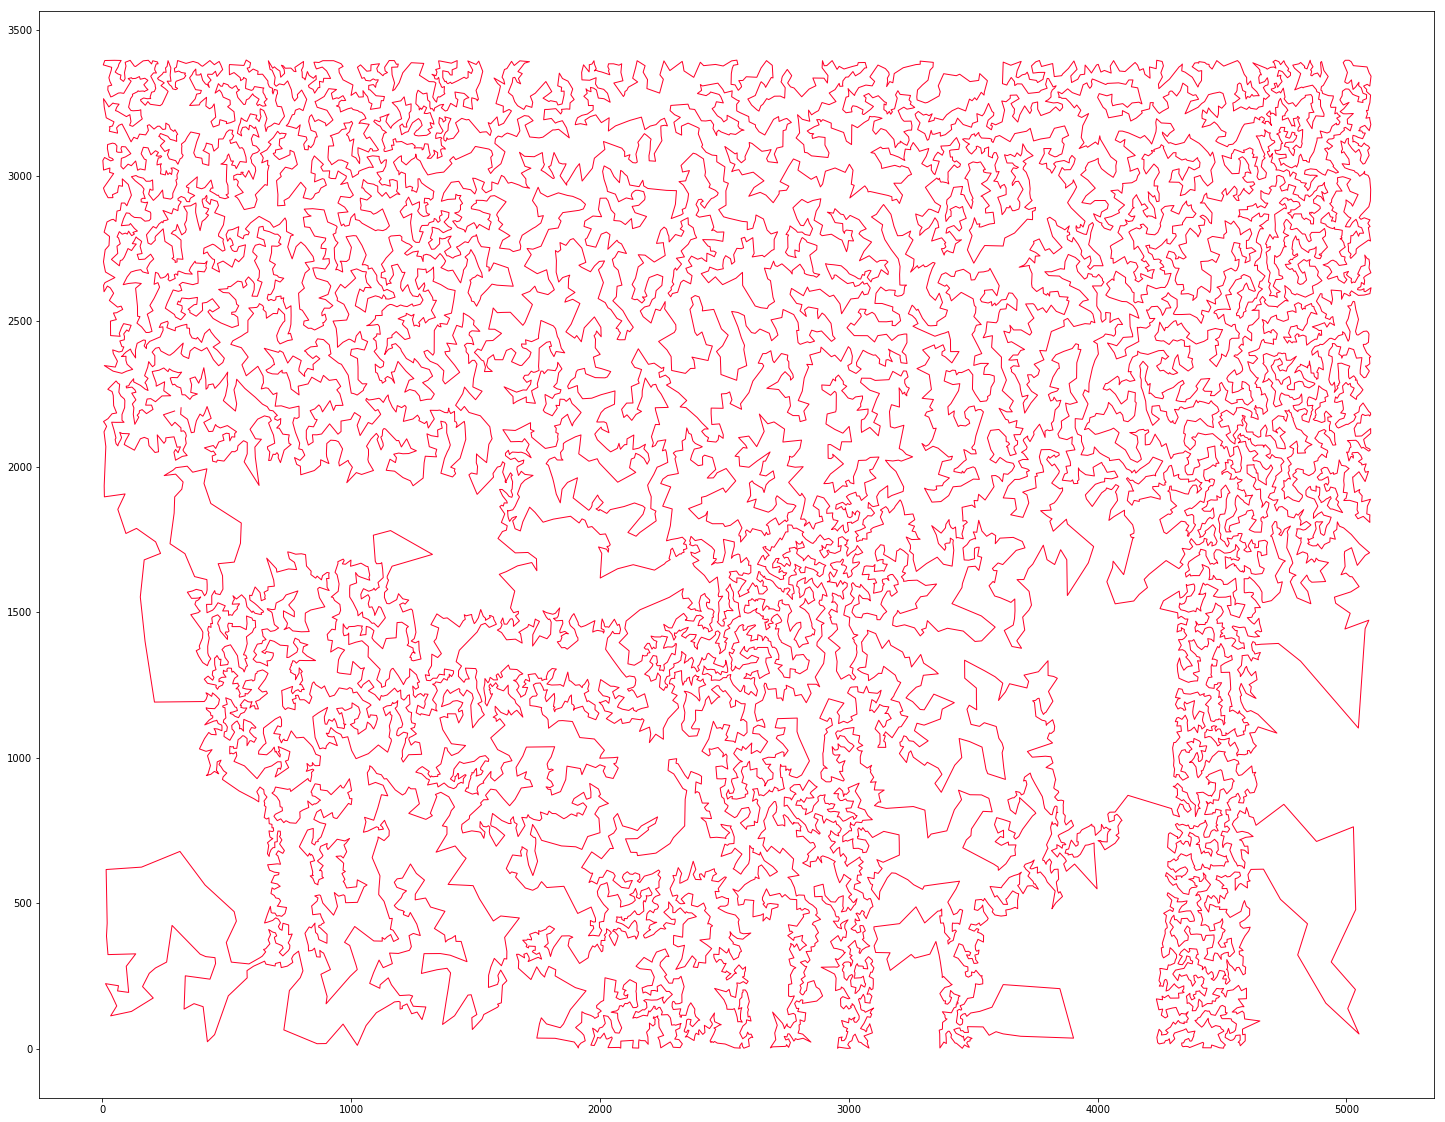

In [111]:
cmap=mpl.cm.gist_rainbow
figsize=(25, 20)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(df_prime.X[tour_data_2], df_prime.Y[tour_data_2], color=cmap(0), linewidth=1)
plt.show()

In [113]:
def plot_tour(route, cities, cmap=mpl.cm.gist_rainbow, figsize=(25, 20)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(route)

    for i in range(201):
        ind = route[n//200*i:min(n, n//200*(i+1)+1)]
        ax.plot(cities.X[ind], cities.Y[ind], color=cmap(i/200.0), linewidth=1)

    ax.plot(cities.X[0], cities.Y[0], marker='*', markersize=15, markerfacecolor='k')
    ax.autoscale(tight=True)
    mpl.colorbar.ColorbarBase(ax=fig.add_axes([0.125, 0.075, 0.775, 0.01]),
                              norm=mpl.colors.Normalize(vmin=0, vmax=n),
                              cmap=cmap, orientation='horizontal')

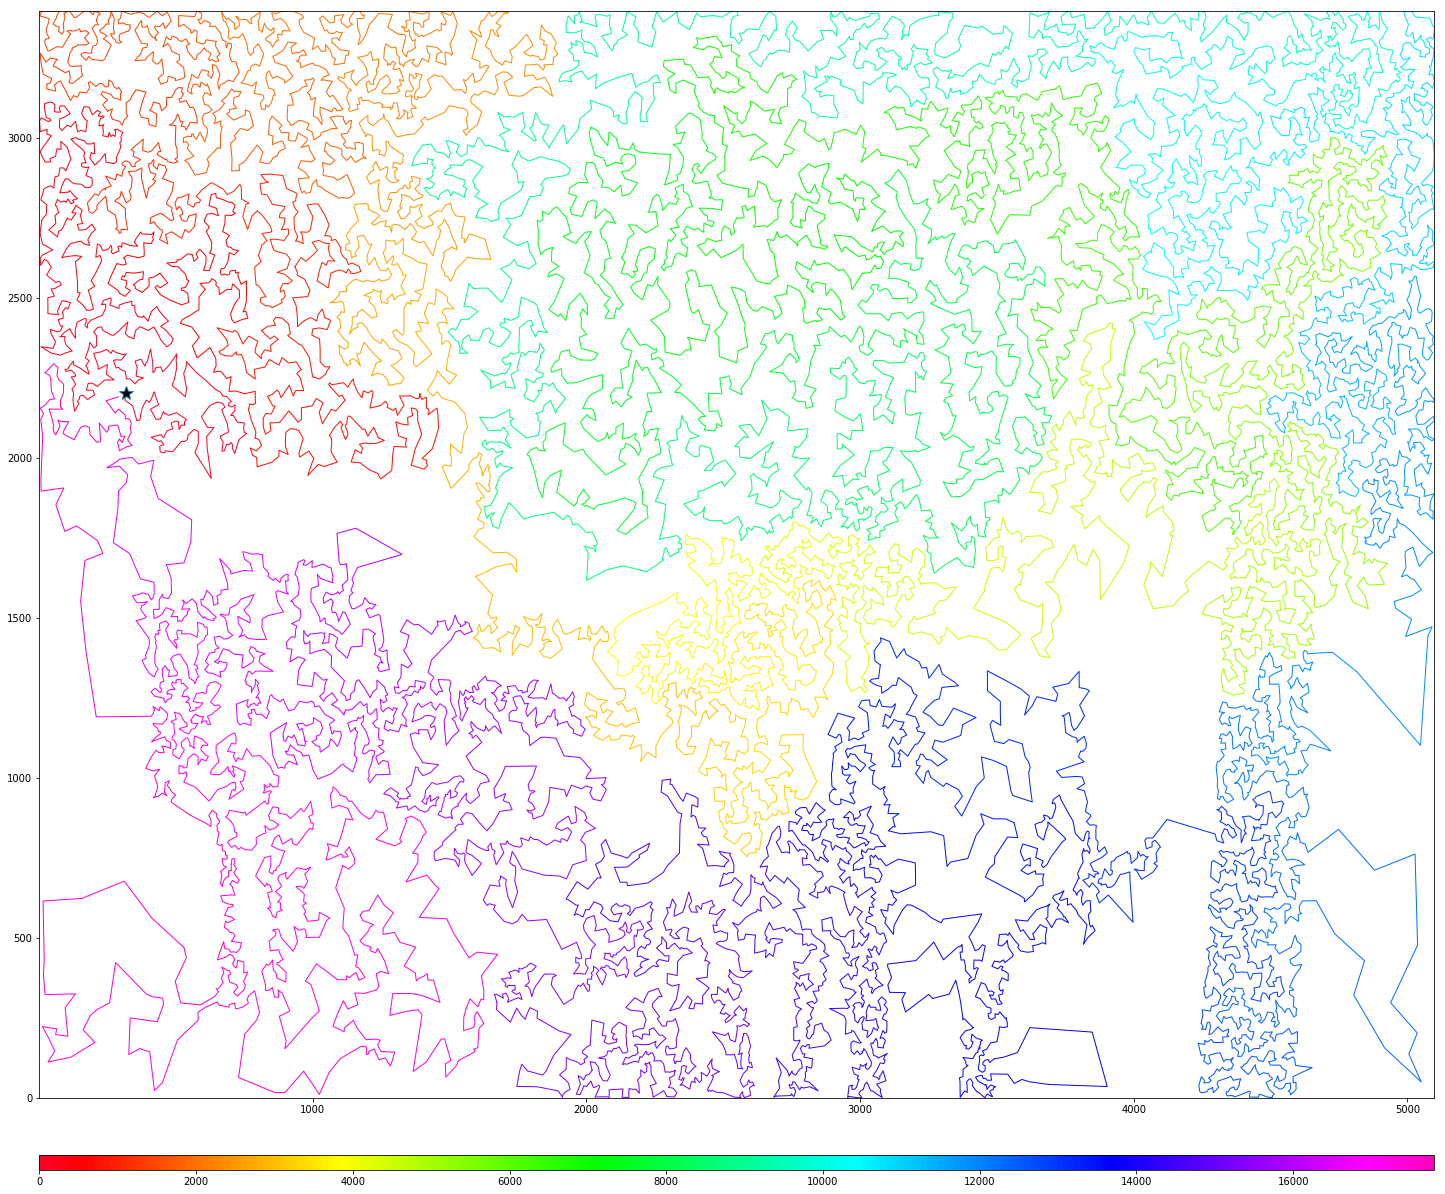

In [114]:
plot_tour(tour_data_2, df_prime)